In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the reference (pharmgkb) and the sg10k dataset
pgkb_df = pd.read_csv('/home/jupyter-yusuf/Consensus/data_viz/References/PharmGKB.csv')
haplotype_df = pd.read_parquet('/home/jupyter-yusuf/Consensus/output/3_haplotypes.parquet')

In [3]:
# Data cleaning
haplotype_df = haplotype_df.rename(columns={'AF': 'SG10K', 'AF_GA_C': 'Chinese', 'AF_GA_I': 'Indian', 'AF_GA_M': 'Malay'})

In [6]:
# Data cleaning
pgkb_df = pgkb_df.fillna(0)
pgkb_df.iloc[:,1:] = pgkb_df.iloc[:,1:].applymap(lambda x: x*100)
pgkb_df = pgkb_df.drop(pgkb_df.columns[[1,6,7,8]], axis=1).copy()
pgkb_df.columns = ["haplotype","American","Central/South Asian","East Asian", "European","African"]

In [7]:
sp_df = pd.merge(haplotype_df, pgkb_df, on = 'haplotype', how = 'left')
sp_df.head()


,haplotype,AC,SG10K,AC_C,AF_C,Chinese,AC_I,AF_I,Indian,AC_M,AF_M,Malay,activity_value,function,American,Central/South Asian,East Asian,European,African
0,*10+*36,866,28.809049,776.0,25.815037,34.094903,10.0,0.332668,3.030303,80.0,2.661344,20.00,0.25,Decreased function,0.14,1.23,34.13,0.00,0.08
1,*1,833,27.711244,587.0,19.527611,25.790861,124.0,4.125083,37.575758,122.0,4.058550,30.50,1.00,Normal function,51.11,28.71,24.53,28.28,7.79
2,*10,529,17.598137,413.0,13.739188,18.145870,11.0,0.365935,3.333333,105.0,3.493014,26.25,0.25,Decreased function,1.44,8.67,43.56,1.57,5.57
3,*2,301,10.013307,197.0,6.553560,8.655536,66.0,2.195609,20.000000,38.0,1.264138,9.50,1.00,Normal function,22.08,29.48,12.05,18.56,19.83
4,*41,142,4.723886,85.0,2.827678,3.734622,40.0,1.330672,12.121212,17.0,0.565536,4.25,0.50,Decreased function,2.33,12.30,2.27,9.24,11.47


In [7]:
# tmp
# sp_df.to_csv('sp_df.tsv', index = False, sep='\t')

In [9]:
pairs = [('SG10K', 'East Asian'), ('Chinese', 'East Asian'), ('Malay', 'East Asian'), ('Indian', 'Central/South Asian')]

for pair in pairs:
    diff_col_name = 'diff_' + pair[0]
    diff = sp_df[pair[0]] - sp_df[pair[1]]
    zscore_col_name = 'zscore_' + diff_col_name
    zscore = np.abs((diff - diff.mean()) / diff.std())
    value = zscore.apply(lambda x: '<3' if x <= 3.0 else '>3')
    sp_df[zscore_col_name] = value
    

# Print the modified DataFrame
filtered_df = sp_df.loc[(sp_df.filter(like='zscore_') == '>3').any(axis=1)]
filtered_df

,haplotype,AC,SG10K,AC_C,AF_C,Chinese,AC_I,AF_I,Indian,AC_M,...,function,American,Central/South Asian,East Asian,European,African,zscore_diff_SG10K,zscore_diff_Chinese,zscore_diff_Malay,zscore_diff_Indian
0,*10+*36,866,28.809049,776.0,25.815037,34.094903,10.0,0.332668,3.030303,80.0,...,Decreased function,0.14,1.23,34.13,0.00,0.08,<3,<3,>3,<3
1,*1,833,27.711244,587.0,19.527611,25.790861,124.0,4.125083,37.575758,122.0,...,Normal function,51.11,28.71,24.53,28.28,7.79,<3,<3,<3,>3
2,*10,529,17.598137,413.0,13.739188,18.145870,11.0,0.365935,3.333333,105.0,...,Decreased function,1.44,8.67,43.56,1.57,5.57,>3,>3,>3,<3
3,*2,301,10.013307,197.0,6.553560,8.655536,66.0,2.195609,20.000000,38.0,...,Normal function,22.08,29.48,12.05,18.56,19.83,<3,<3,<3,>3
33,*4+*4,1,0.033267,0.0,0.000000,0.000000,1.0,0.033267,0.303030,0.0,...,No function,NaN,NaN,NaN,NaN,NaN,>3,>3,>3,>3


# 1. Heatmap correlation PharmGKB and SG10k

Text(0.5, 1.0, 'Heatmap Correlation of Haplotype Frequency from PharmGKB and SG10K')

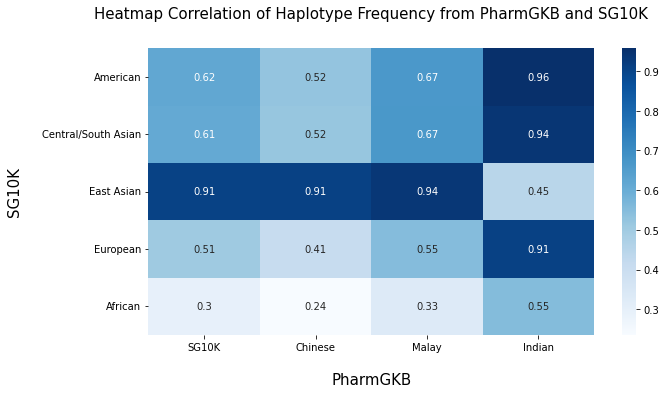

In [10]:
sp_corr = sp_df[['SG10K', 'Chinese', 'Malay', 'Indian', 'American', 'Central/South Asian', 'East Asian', 'European', 'African']].corr()

sp_corr = sp_corr.iloc[4:,0:4]
# sp_corr
plt.figure(figsize = (10,5))
chart = sns.heatmap(sp_corr, annot=True, cmap = 'Blues')
plt.xlabel('PharmGKB', fontsize = 15, labelpad = 20)
plt.ylabel('SG10K', fontsize = 15, labelpad= 20)
plt.tight_layout()
plt.title('Heatmap Correlation of Haplotype Frequency from PharmGKB and SG10K', fontsize = 15, pad = 30)


In [11]:
def sp_pharmgkb(x,y,hue,data, ax, palette, title):

    sns.scatterplot(ax= ax, x = x ,y = y, data = data, hue = hue, legend = None, palette = palette)
    ax.grid(alpha = .3)
    ax.text(25,1,'r = %s' % data[x].corr(data[y]).round(3),weight='semibold')
    ax.plot([0.5, 45], [0, 45], linewidth=2, alpha = .3)
    ax.set(ylim = (0,45), xlim = (0,45))
    ax.set_title(title, fontdict=None, loc='center', pad=None, weight='semibold')
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel = y, weight =  'semibold')

    #temporary modify data[hue][line] == '1'
    for line in range(0,data.shape[0]):
        if data[hue][line] == '>3':
            ax.text(data[x][line]+0.2, data[y][line], data['haplotype'][line], horizontalalignment='left', size='small', color='black')



In [12]:
def sp_pharmgkb(x, y, hue, data, ax, palette, title):
    data = data.copy()  # to avoid changing the original data
    data[x] = np.arcsin(data[x])  # apply arcsine transformation
    data[y] = np.arcsin(data[y])  # apply arcsine transformation
    sns.scatterplot(ax=ax, x=x, y=y, data=data, hue=hue, legend=None, palette=palette)
    ax.grid(alpha=.3)
    ax.text(0.5, 0.1, 'r = %s' % data[x].corr(data[y]).round(3), weight='semibold')
    ax.plot([0, 1], [0, 1], linewidth=2, alpha=.3)
    ax.set(ylim=(0, 1), xlim=(0, 1))
    ax.set_title(title, fontdict=None, loc='center', pad=None, weight='semibold')
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel=y, weight='semibold')

    # temporary modify data[hue][line] == '1'
    for line in range(0, data.shape[0]):
        if data[hue][line] == '>3':
            ax.text(data[x][line] + 0.02, data[y][line], data['haplotype'][line], horizontalalignment='left', size='small', color='black')

# 2. Scatterplot comparison

/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

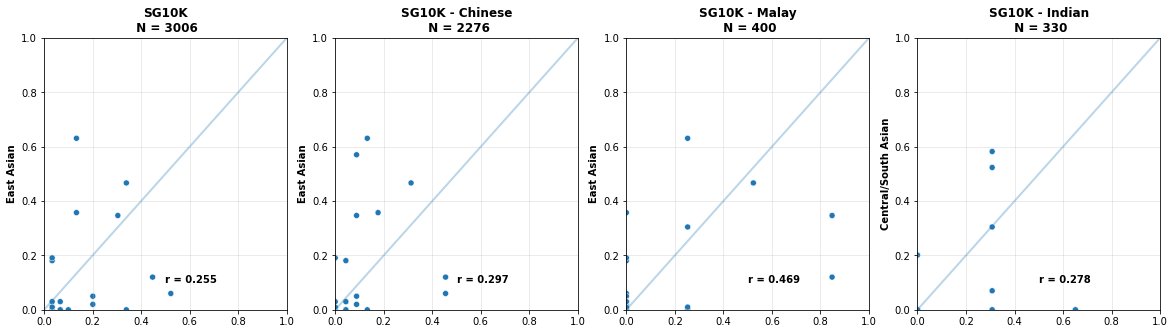

In [13]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey = False,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)



sp_pharmgkb(x = 'SG10K',y = 'East Asian', data = sp_df, ax = axes[0], hue = 'zscore_diff_SG10K', palette=["C0", "C1"], title = f"SG10K\n N = {sp_df['AC'].sum()}")
sp_pharmgkb(x = 'Chinese',y = 'East Asian', data = sp_df, ax = axes[1], hue = 'zscore_diff_Chinese', palette=["C0", "C1"], title = f'SG10K - Chinese\n N = {int(sp_df["AC_C"].sum())}')
sp_pharmgkb(x = 'Malay',y = 'East Asian', data = sp_df, ax = axes[2], hue = 'zscore_diff_Malay', palette=["C1", "C0"], title = f'SG10K - Malay\n N = {int(sp_df["AC_M"].sum())}')
sp_pharmgkb(x = 'Indian',y = 'Central/South Asian', data = sp_df, ax = axes[3], hue = 'zscore_diff_Indian', palette=["C0", "C1"], title = f'SG10K - Indian\n N = {int(sp_df["AC_I"].sum())}')

Comparison with log10

In [14]:
def sp_pharmgkb(x,y,hue,data, ax, palette, title):

    x_log = np.log10(data[x])
    y_log = np.log10(data[y])

    sns.scatterplot(ax= ax, x = x_log ,y = y_log, data = data, hue = hue, legend = None, palette = palette)
    ax.grid(alpha = .3)
    ax.text(0.5, 0.1, 'r = %s' % data[x].corr(data[y]).round(3), weight='semibold', transform=ax.transAxes)
    ax.plot([np.log10(0.5), np.log10(45)], [np.log10(0.5), np.log10(45)], linewidth=2, alpha=.3)  # line with slope 1
    ax.set(ylim=(np.log10(0.5), np.log10(45)), xlim=(np.log10(0.5), np.log10(45)))  # Set same limits
    ax.set_title(title, fontdict=None, loc='center', pad=None, weight='semibold')
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel = y, weight =  'semibold')

    #temporary modify data[hue][line] == '1'
    for line in range(0,data.shape[0]):
        if data[hue][line] == '>3':
            ax.text(np.log10(data[x][line]+0.2), np.log10(data[y][line]), data['haplotype'][line], horizontalalignment='left', size='small', color='black')



/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/jupyter-yusuf/.conda/envs/cyp2d6/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

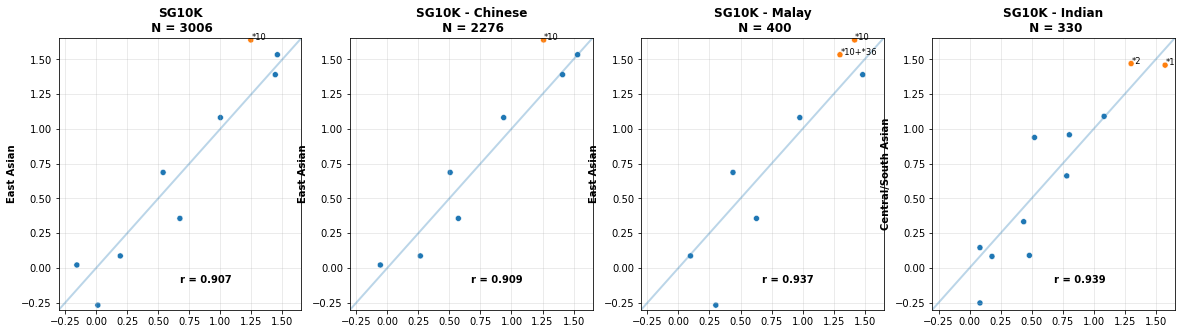

In [15]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey = False,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)



sp_pharmgkb(x = 'SG10K',y = 'East Asian', data = sp_df, ax = axes[0], hue = 'zscore_diff_SG10K', palette=["C0", "C1"], title = f"SG10K\n N = {sp_df['AC'].sum()}")
sp_pharmgkb(x = 'Chinese',y = 'East Asian', data = sp_df, ax = axes[1], hue = 'zscore_diff_Chinese', palette=["C0", "C1"], title = f'SG10K - Chinese\n N = {int(sp_df["AC_C"].sum())}')
sp_pharmgkb(x = 'Malay',y = 'East Asian', data = sp_df, ax = axes[2], hue = 'zscore_diff_Malay', palette=["C1", "C0"], title = f'SG10K - Malay\n N = {int(sp_df["AC_M"].sum())}')
sp_pharmgkb(x = 'Indian',y = 'Central/South Asian', data = sp_df, ax = axes[3], hue = 'zscore_diff_Indian', palette=["C0", "C1"], title = f'SG10K - Indian\n N = {int(sp_df["AC_I"].sum())}')

## Using frequency to make it smaller

In [18]:


def sp_pharmgkb(x, y, hue, data, ax, palette, title):
    data = data.copy()  # to avoid changing the original data
    data[x] = data[x]/100  # divide by 100 to get frequency
    data[y] = data[y]/100  # divide by 100
    sns.scatterplot(ax=ax, x=x, y=y, data=data, hue=hue, legend=None, palette=palette)
    ax.grid(alpha=.3)
    ax.text(0.3, 0.1, 'r = %s' % data[x].corr(data[y]).round(3), weight='semibold')
    ax.plot([0, 1], [0, 1], linewidth=2, alpha=.3)
    ax.set(ylim=(0, 0.5), xlim=(0, 0.5))
    ax.set_title(title, fontdict=None, loc='center', pad=None, weight='semibold')
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel=y, weight='semibold')

    # temporary modify data[hue][line] == '1'
    for line in range(0, data.shape[0]):
        if data[hue][line] == '>3':
            ax.text(data[x][line] + 0.02, data[y][line], data['haplotype'][line], horizontalalignment='left', size='small', color='black')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


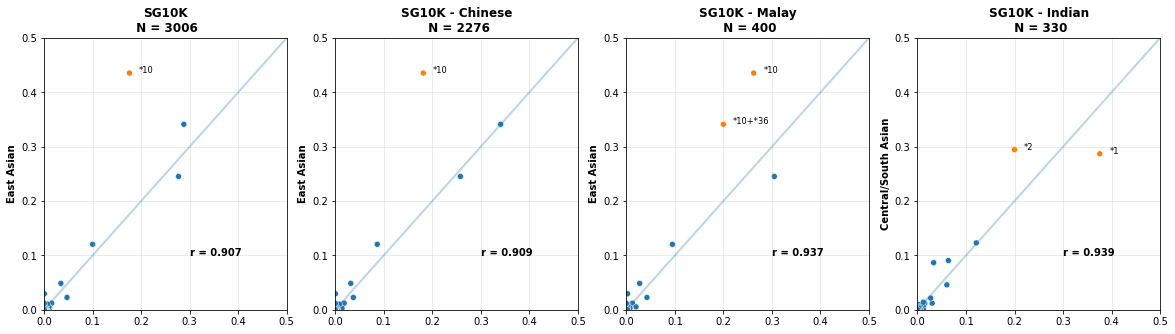

In [19]:
fig, axes = plt.subplots(1, 4, sharex=False, sharey = False,figsize=(20,5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)



sp_pharmgkb(x = 'SG10K',y = 'East Asian', data = sp_df, ax = axes[0], hue = 'zscore_diff_SG10K', palette=["C0", "C1"], title = f"SG10K\n N = {sp_df['AC'].sum()}")
sp_pharmgkb(x = 'Chinese',y = 'East Asian', data = sp_df, ax = axes[1], hue = 'zscore_diff_Chinese', palette=["C0", "C1"], title = f'SG10K - Chinese\n N = {int(sp_df["AC_C"].sum())}')
sp_pharmgkb(x = 'Malay',y = 'East Asian', data = sp_df, ax = axes[2], hue = 'zscore_diff_Malay', palette=["C1", "C0"], title = f'SG10K - Malay\n N = {int(sp_df["AC_M"].sum())}')
sp_pharmgkb(x = 'Indian',y = 'Central/South Asian', data = sp_df, ax = axes[3], hue = 'zscore_diff_Indian', palette=["C0", "C1"], title = f'SG10K - Indian\n N = {int(sp_df["AC_I"].sum())}')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


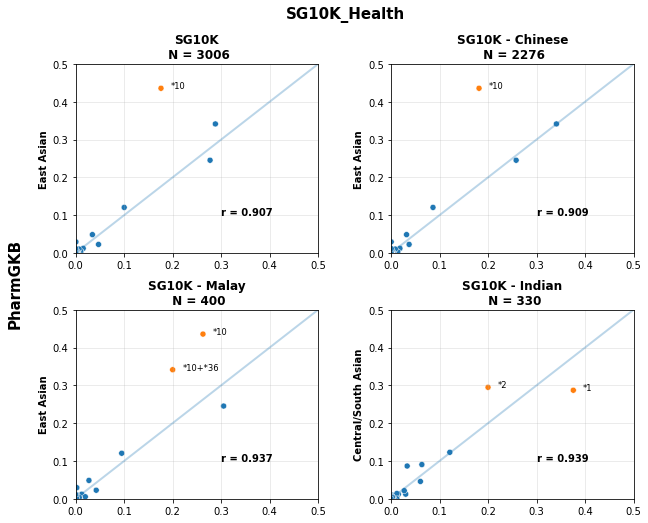

In [33]:
fig, axes = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(10, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.3)

sp_pharmgkb(x='SG10K', y='East Asian', data=sp_df, ax=axes[0, 0], hue='zscore_diff_SG10K', palette=["C0", "C1"], title=f"SG10K\n N = {sp_df['AC'].sum()}")

sp_pharmgkb(x='Chinese', y='East Asian', data=sp_df, ax=axes[0, 1], hue='zscore_diff_Chinese', palette=["C0", "C1"], title=f'SG10K - Chinese\n N = {int(sp_df["AC_C"].sum())}')

sp_pharmgkb(x='Malay', y='East Asian', data=sp_df, ax=axes[1, 0], hue='zscore_diff_Malay', palette=["C1", "C0"], title=f'SG10K - Malay\n N = {int(sp_df["AC_M"].sum())}')

sp_pharmgkb(x='Indian', y='Central/South Asian', data=sp_df, ax=axes[1, 1], hue='zscore_diff_Indian', palette=["C0", "C1"], title=f'SG10K - Indian\n N = {int(sp_df["AC_I"].sum())}')

fig.text(0.03, 0.5, 'PharmGKB', va='center', rotation='vertical', fontsize=15, weight='semibold')
fig.suptitle('SG10K_Health', x=0.5, y=0.98, horizontalalignment='center', fontsize=15, weight='semibold')

plt.show()
